Audio classification

In [ ]:
import numpy as np  # Importing NumPy library for numerical computations
import pandas as pd  # Importing Pandas library for data manipulation and analysis
import matplotlib.pyplot as plt  # Importing Matplotlib library for data visualization
import seaborn as sns  # Importing Seaborn library for enhanced data visualization
import time  # Importing Time module for time-related tasks
import os  # Importing OS module for interacting with the operating system
import librosa as librosa  # Importing Librosa library for audio processing
import librosa.display  # Importing Librosa display module for visualizing audio data
from tqdm.notebook import tqdm, trange  # Importing tqdm library for progress bars
import IPython.display as ipd  # Importing IPython display module for multimedia content display
from sklearn.preprocessing import StandardScaler  # Importing StandardScaler for data scaling
from sklearn.model_selection import train_test_split  # Importing train_test_split for data splitting
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder for label encoding
import tensorflow as tf  # Importing TensorFlow for deep learning
from sklearn.metrics import accuracy_score  # Importing accuracy_score for model evaluation
from tensorflow.keras.optimizers import Adam  # Importing Adam optimizer for model optimization
from tensorflow.keras.layers import (Input, UpSampling2D, concatenate, Conv1D, Conv2D, Flatten, MaxPool2D, MaxPooling2D,
                                    MaxPooling1D, Dense, Dropout, BatchNormalization, Activation, Flatten, LSTM)  # Importing various layers for neural network architecture
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential  # Importing Model and Sequential for defining neural network models
from tensorflow.keras.utils import to_categorical  # Importing to_categorical for one-hot encoding
from tensorflow.keras.losses import categorical_crossentropy  # Importing categorical_crossentropy loss function
from tqdm import tqdm  # Importing tqdm for progress bars
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Importing ModelCheckpoint and EarlyStopping for model training callbacks
from sklearn.feature_selection import mutual_info_regression  # Importing mutual_info_regression for feature selection
from IPython.display import display  # Importing display for multimedia content display
import IPython.display as ipd  # Importing IPython display module for multimedia content display
import warnings  # Importing warnings module for suppressing warnings

warnings.filterwarnings('ignore')  # Suppressing warnings from being printed


Loading the dataset and metadata

In [2]:
main_audio = "./audio/"  # Setting the path for the main audio directory

In [3]:
main_df = pd.read_csv(main_audio + "data.csv")  # Reading the data.csv file from the main audio directory and storing it in the main_df DataFrame
main_df.head()  # Displaying the first few rows of the DataFrame

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


checking the shape of the dataframe

In [4]:
main_df.shape  # Getting the shape of the main_df DataFrame

(8732, 8)

viewing the statistics of dataframe

In [5]:
main_df.describe()  # Generating summary statistics of the main_df DataFrame

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


checking for missing values

In [29]:
main_df.isna().sum()  # Checking the number of missing values in each column of the main_df DataFrame


slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

there are no missing values in the dataframe

checking the shape and sampling rate of an audio file

In [7]:
y, sr = librosa.load(main_audio + 'fold5/100032-3-0-0.wav')  # Loading the audio file from the main_audio directory and storing the waveform data in 'y' and the sampling rate in 'sr'
print("Shape :", y.shape)  # Printing the shape of the waveform data
print("Sampling rate: ", sr)  # Printing the sampling rate of the audio file


Shape : (7002,)
Sampling rate:  22050


in the next cell I am defining the lable dictionary which will help me manipulate the data for viewing the waveforms of all the classes

In [8]:
# Defining the dictionary of labels
labels = main_df[['classID', 'class']].value_counts().keys().sort_values()  # Extracting unique classIDs and class names from main_df, sorting them, and storing in 'labels'
label_dict = dict(labels)  # Converting 'labels' into a dictionary with classID as key and class name as value, and storing in 'label_dict'

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In this cell I am declaring a function to load audio files available in the dataset with their filename.

In [ ]:
def load_wave(folder, file_name):
    # Loading waveform data and sampling rate from audio file
    y, sr = librosa.load(main_audio + 'fold' + folder + '/' + file_name, sr=None, mono=False)
    return y, sr


In this function the file would be sorted using their ClassID

In [ ]:
def get_audio_file_by_classId(data,classId) :
    # Extracting file locations (fold and slice_file_name) for a given classID from data DataFrame
    file_locations = [[row['fold'], row['slice_file_name']] for index, row in data[data['classID'] == classId].reset_index().iterrows()]
    return file_locations

in this function all of the previously fetched information would be stored in one place to call the files as required

In [ ]:
def get_sample_by_classId(data, sample, classId) :
    # Grouping data DataFrame by 'classID' and sampling 'sample' number of rows from each group
    groups = data.groupby("classID").sample(sample)
    # Calling get_audio_file_by_classId() function to get file locations for the sampled data of the given classID
    return get_audio_file_by_classId(groups,classId)

This function Is the end result of the previously declared functions as I want to visualise the time-series of the data in the form of amplitude to analyse if the amplitude features are similar if the ampliture features are similar the model required would not require a huge amount of inferencing power as the model architecture would require less memory to run.

In [9]:

def plot_amplitude(classId, sample):
    # Getting file locations for the sampled data of the given classId
    files = get_sample_by_classId(main_df, sample, classId)
    # Creating subplots with shared x-axis and setting the figure size
    fig, ax = plt.subplots(nrows=sample, sharex='all', figsize=(20, 10))
    # Looping through the files and plotting the waveforms
    for idx, file in enumerate(files):
        # Loading waveform data and sampling rate
        y, sr = load_wave(f'{file[0]}',f'{file[1]}')        
        # Setting y-axis limits to start from 0
        ax[idx].set_ylim(ymin=0)        
        # Plotting the waveform using librosa.display.waveshow()
        librosa.display.waveshow(y, sr=22050, ax=ax[idx])       
        # Setting the title of each subplot with the file name
        ax[idx].set_title(f'File: {file[1]}')  
    # Adding a title to the overall figure with the class name
    fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
    plt.suptitle(f"Class : {label_dict[classId]}", fontsize=14)   
    # Adjusting the spacing between subplots
    fig.subplots_adjust(hspace=0.4)   
    # Displaying the plot
    plt.show()    
    # Setting the grid property of axes to True
    plt.rcParams['axes.grid'] = True


in this cell I am running a for loop according to our ClassID as we have 10 classes available in the dataset hence the value is 10 in range.

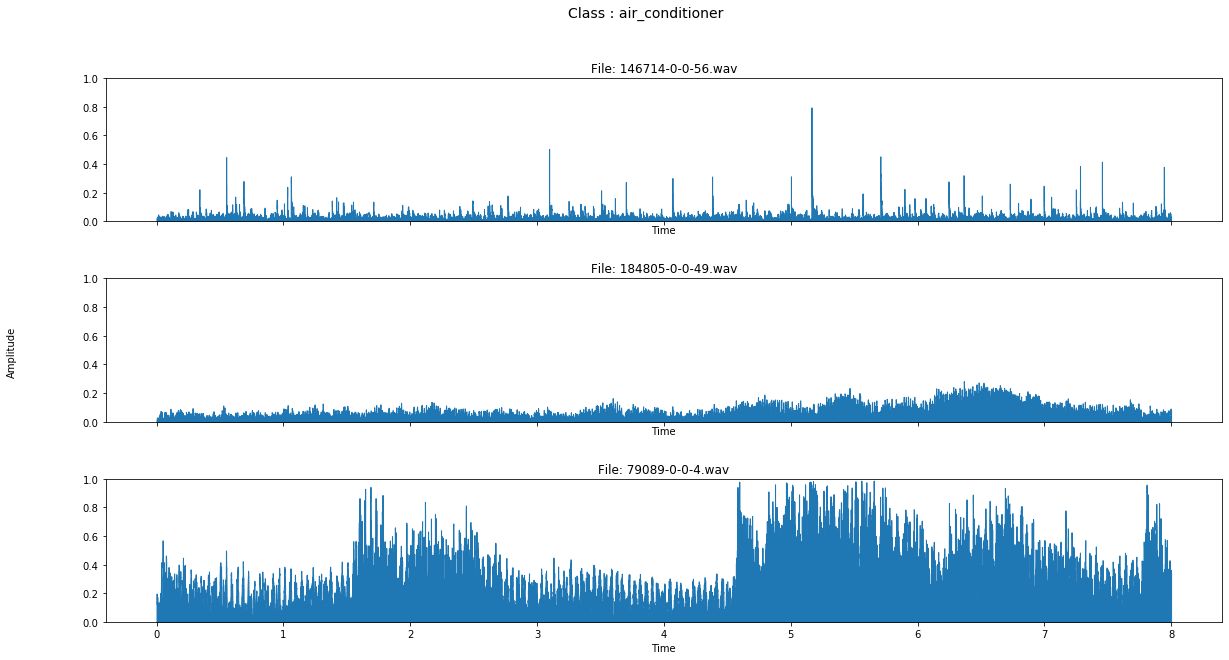

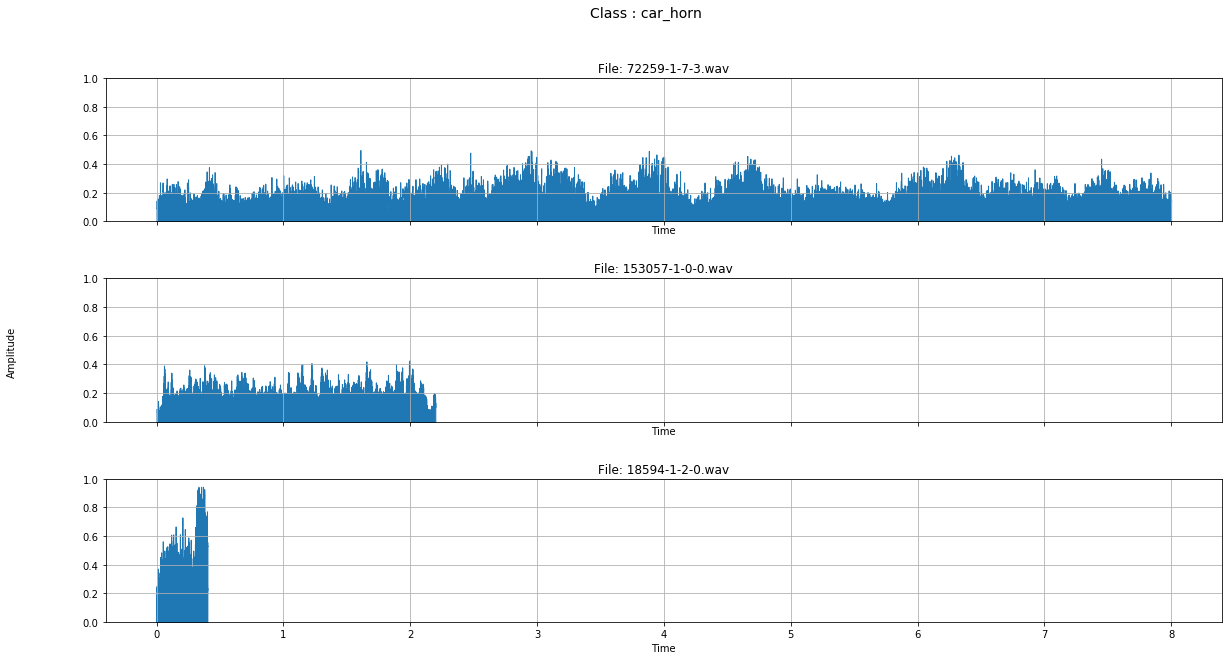

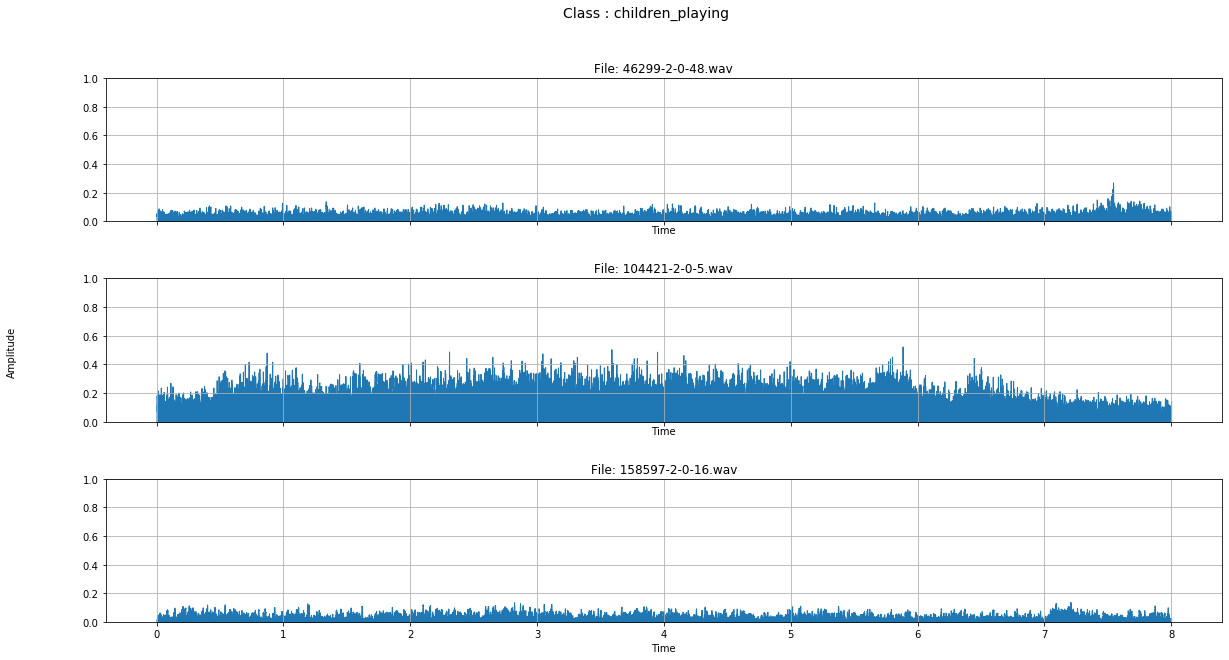

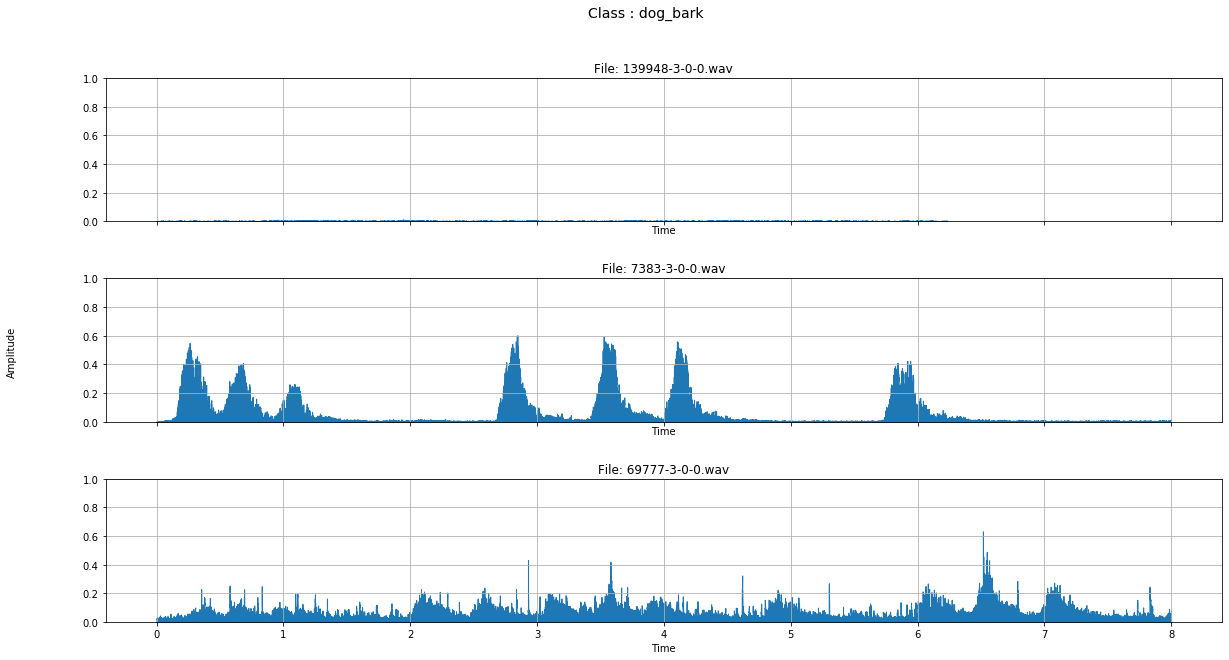

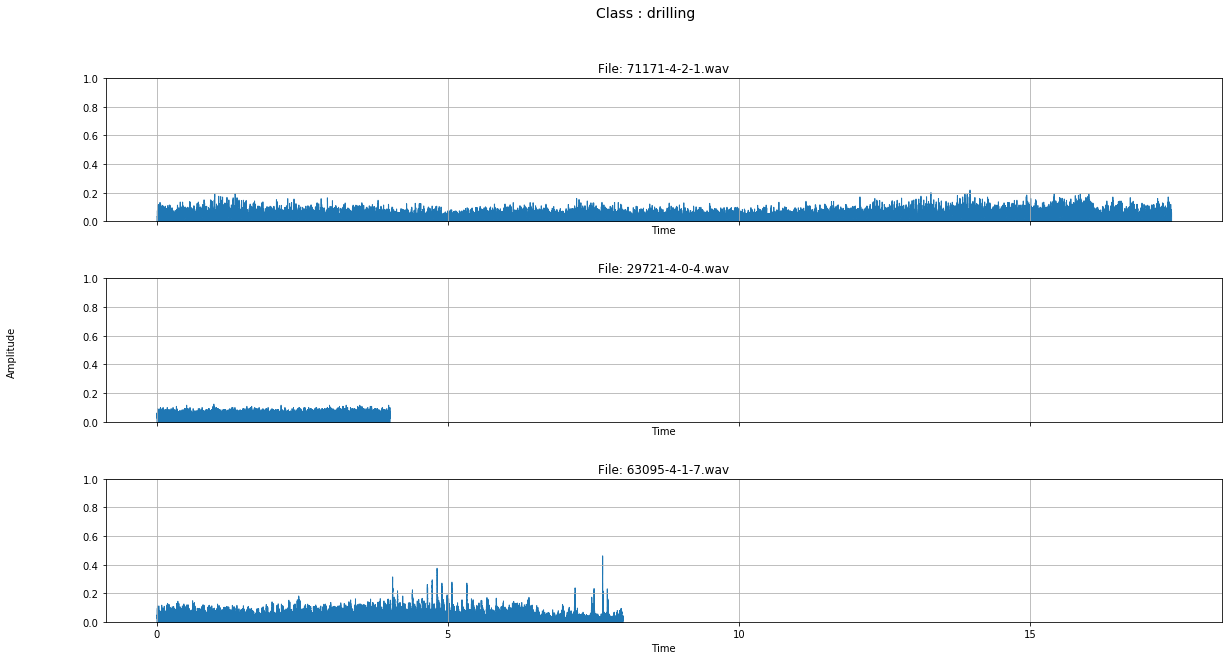

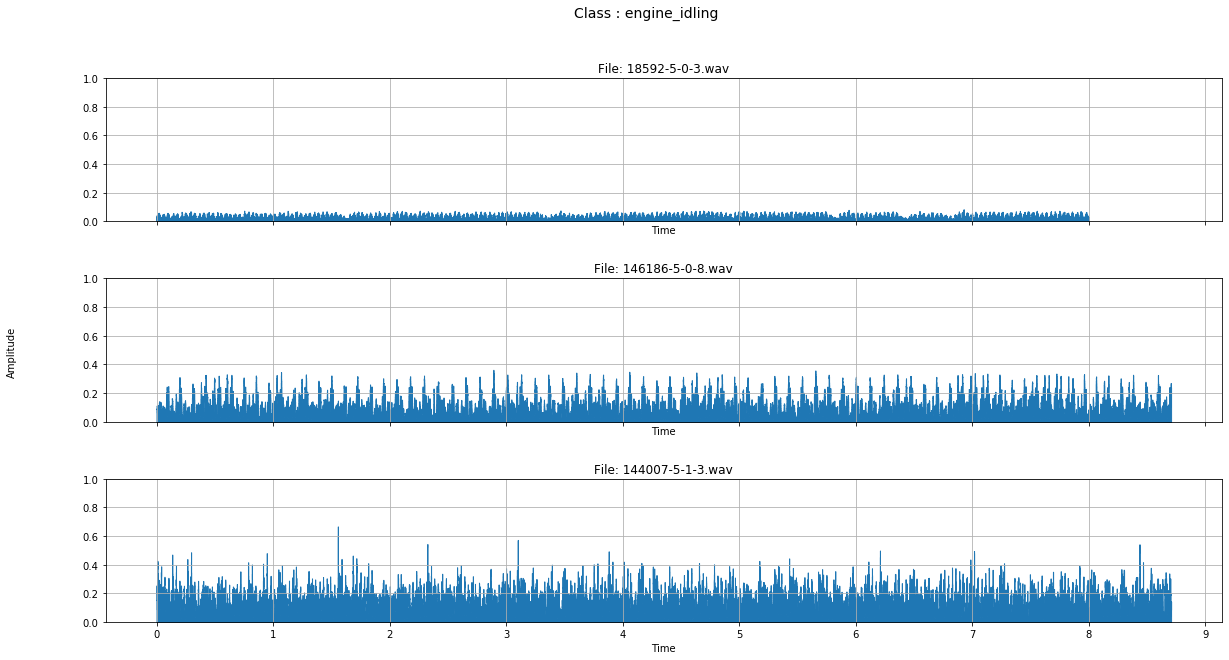

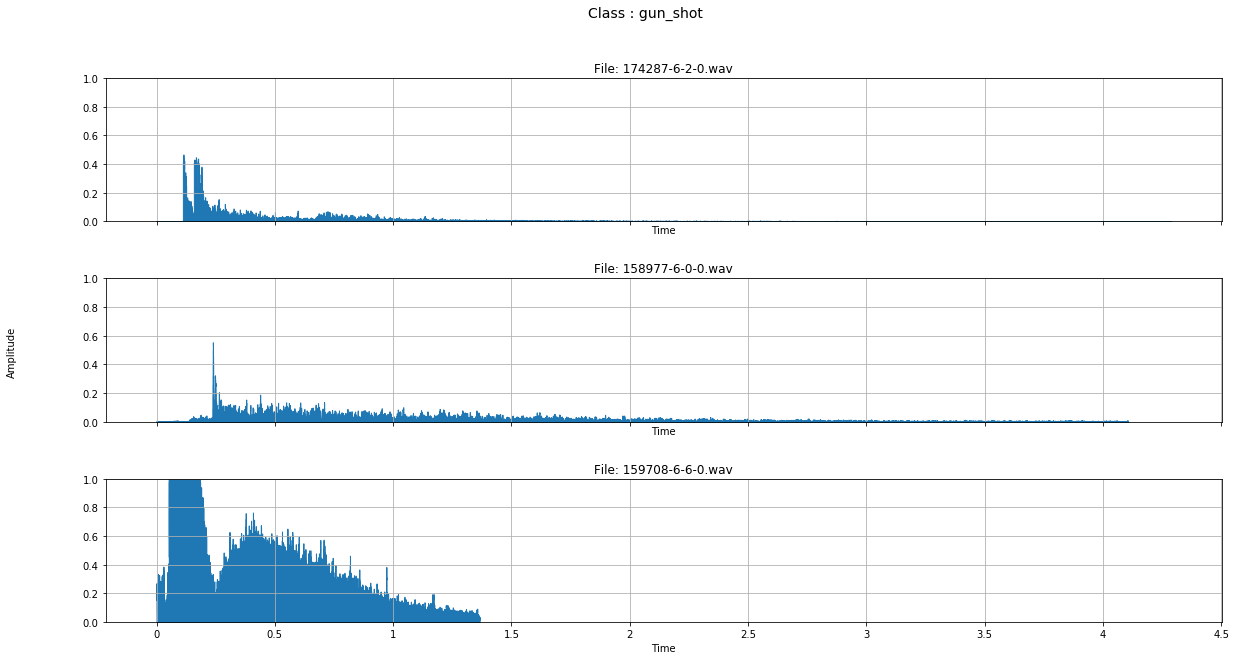

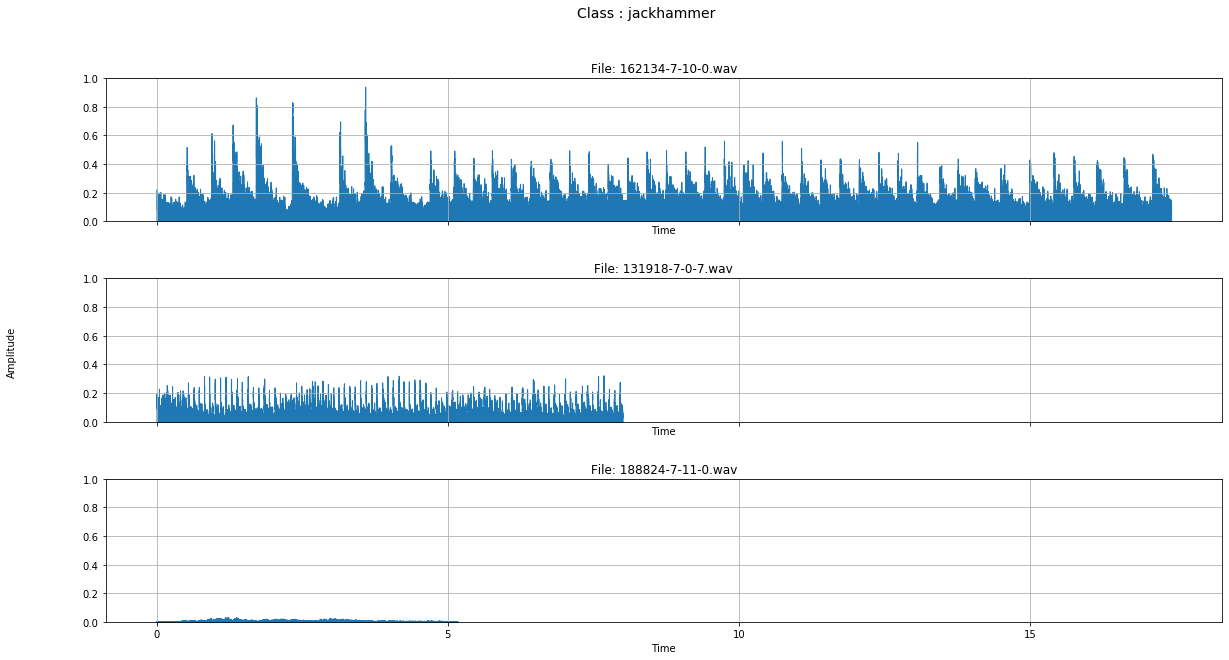

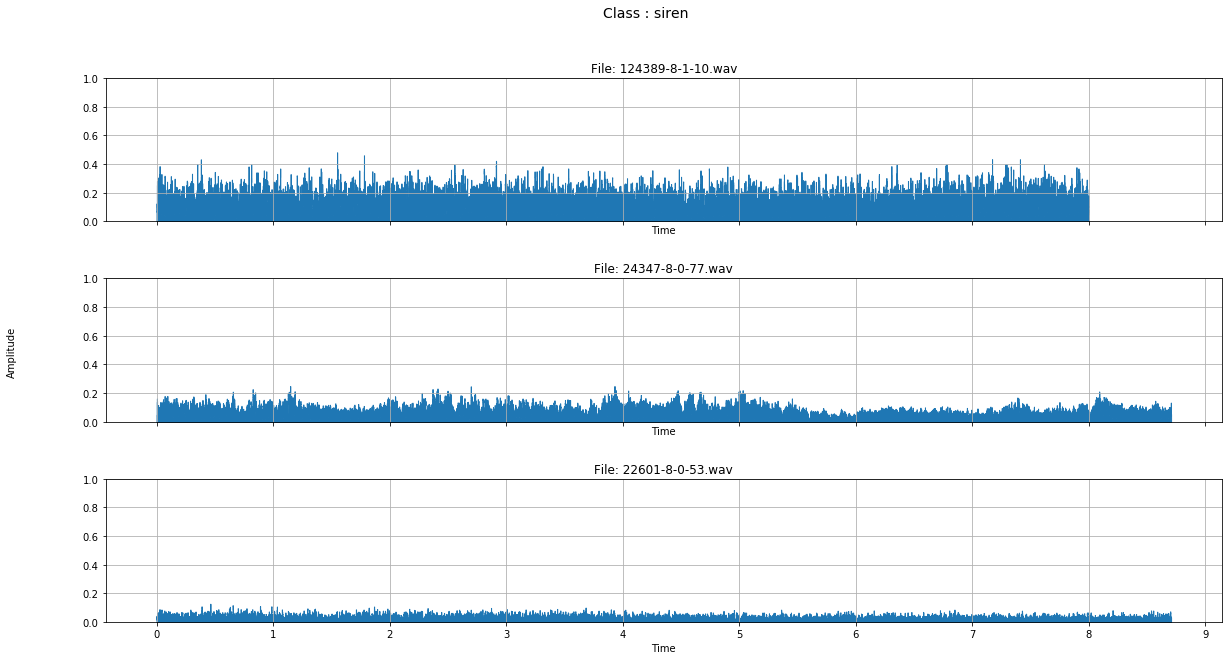

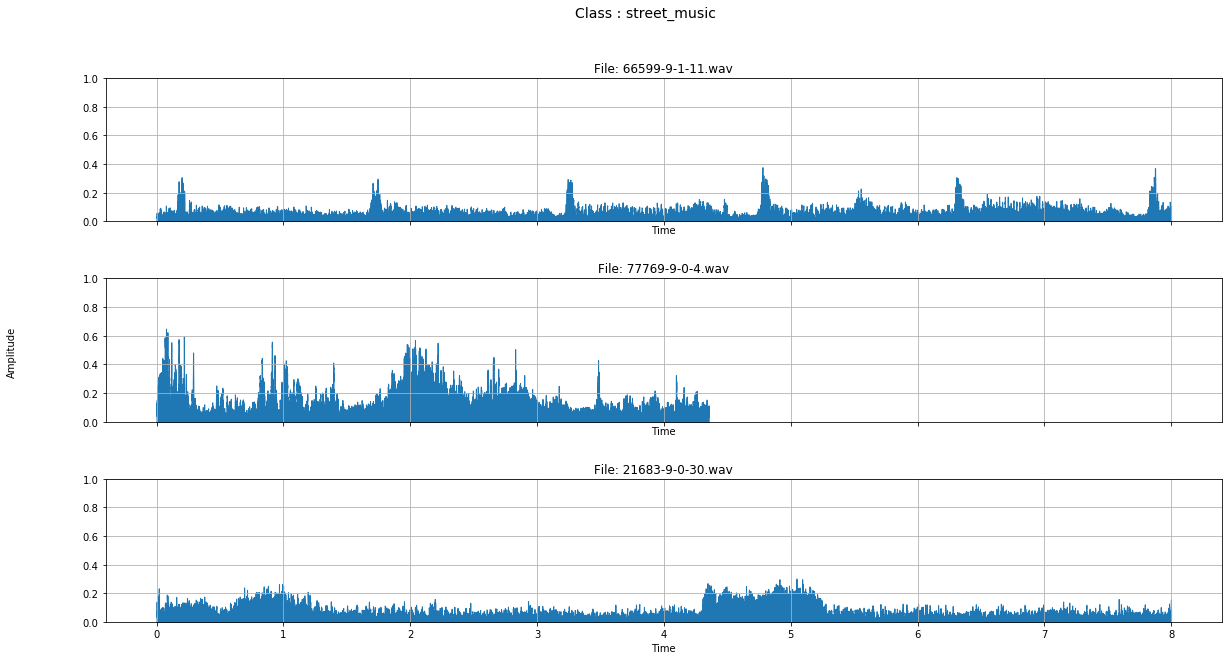

In [10]:
# Looping through a range of classIDs (0 to 9) and plotting 3 amplitude waveforms for each classID
for i in range(10):
    plot_amplitude(i, 3)


Upon analysis of the the amplitude plots it is evident that the amplitude features are not similar hence we would proceed to perform MFCC for feature extraction

lets check the class dsitribution of the data to choose a strategy forward.

Text(0, 873.7, 'Mean = 873.20')

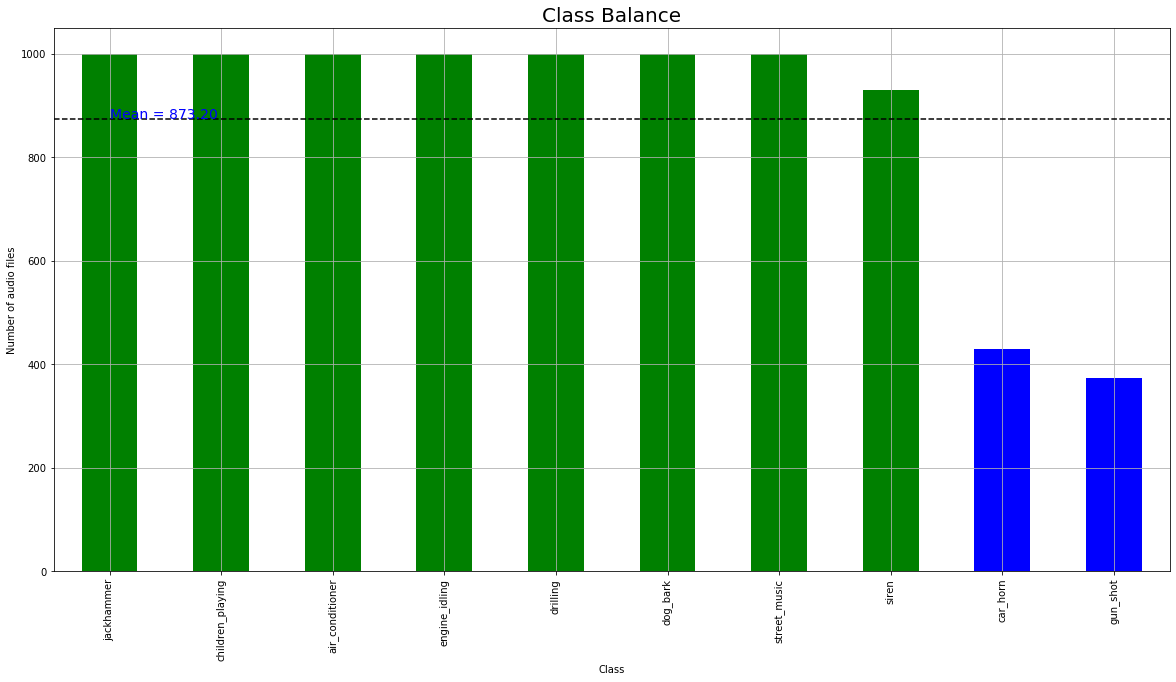

In [11]:
# Calculating and plotting the class balance
class_group = main_df['class'].value_counts()
# Calculating the mean number of audio files per class
mean = class_group.mean()
# Assigning colors to the bars based on whether the count is above or below the mean
colors = ['green' if x >= mean else 'blue' for x in class_group]
# Creating a bar plot of class counts
plot = class_group.plot(
    kind='bar', 
    figsize=(20,10),
    color=colors
)
# Setting the title, x-axis label, and y-axis label for the plot
plot.set_title("Class Balance", fontsize=20)
plot.set_xlabel("Class")
plot.set_ylabel("Number of audio files")
# Adding a grid to the plot
plot.grid(True)
# Adding a horizontal line for the mean count and labeling it
plot.axhline(mean, color='black', linestyle='--')
plot.text(0, mean + 0.5, f'Mean = {mean:.2f}', color='blue', fontsize=14)


upon analysing the class distribution it is evident that we need balance the class as our target class is not in majority.

# Extracting MFCC features

the cell below is defining the coefficient number of MFCC, the maximum length of a wav file and the sampling rate of the wav files available in the dataset. these are declared here to assign it as a global constant, more over these values are calculated throught Logarithmic filter bank outputs are produced and multiplied by 20 to obtain spectral envelopes in decibels. the maximum length is set to a standard and sampling frequency rate is set to this rate to avoid any clashes of sampling frequency with files which are not loaded through librosa as librosa automatically converts these files to 22.05Khz sampling frequency.

In [12]:
# Setting the number of MFCC coefficients, maximum length of MFCC sequence, and sample rate
N_MFCC = 20
MFCC_MAX_LEN = 900
RATE = 22050

now I am going to Extract the MFCC features by declaring one function and these features would be scaled and a for loop is used which will iterate the function through the whole dataset to provide to extract the MFCC of all the audio files available. 

In [13]:
# Define a function to extract features from an audio file using librosa
def features_extract(file):
    audio,sample_rate = librosa.load(file_name,) # Load the audio file and get its sample rate
    feature = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=N_MFCC) # Extract MFCC features
    scaled_feature = np.mean(feature.T,axis=0) # Scale the features
    return scaled_feature

extracted = []

# Loop through the rows of the main_df dataframe and extract features from audio files
for index_num,row in tqdm(main_df.iterrows()):
    file_name = os.path.join(os.path.abspath(main_audio),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) # Construct the file path
    final_class_labels = row['class'] # Get the final class label for the audio file
    data= features_extract(file_name) # Extract features from the audio file
    extracted.append([data,final_class_labels]) # Append the features and class label to the extracted list


8732it [01:41, 86.00it/s] 


Now that the features are extracted as a tuple I am going to create a new dataset by combining the extracted features and their relevant classes to enable our system to analyse teh information in the audio files.

In [14]:
# Create a new DataFrame from the extracted features and class labels
ext_df = pd.DataFrame(extracted, columns=['feature', 'class'])

,feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.784523, 1...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.090256, -36.75108, 26.816488,...",car_horn
8730,"[-336.92386, 115.3139, -44.84709, 24.968985, -...",car_horn


In the cell below I am converting the data extracted from a tuple to list and then to and array to be able to split the data effectively.

In [15]:
# Convert 'feature' and 'class' columns of ext_df DataFrame into NumPy arrays X and y
X = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())


this function is responsible to evaluate and plot the training loss for visualising the loss of training and validation to check if the model is overfitting, underfitting or a good fit.

In [16]:
def plot_history_perf(history):
    """
    Plots the training and validation accuracy and loss from the history object of a trained model.
    Args:
        history (keras.callbacks.History): History object from model training
    Returns:
        None
    """
    # Create a 1x2 subplot figure with two subplots for accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    # Iterate over accuracy and loss metrics
    for i, met in enumerate(['accuracy', 'loss']):
        # Plot training accuracy/loss
        ax[i].plot(history.history[met])
        # Plot validation accuracy/loss
        ax[i].plot(history.history['val_' + met])
        # Set subplot title
        ax[i].set_title('Model {}'.format(met))
        # Set x-axis label
        ax[i].set_xlabel('epochs')
        # Set y-axis label
        ax[i].set_ylabel(met)
        # Add legend for train and val
        ax[i].legend(['train', 'val'])


In the cell below I am splitting the data into three portions train, validation and test to use for their respective purpose.

In [17]:
# Split the data into training and testing sets
x_new, x_test, y_new, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Further split the new data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_new, y_new, test_size=0.1, random_state=42)
# Print the number of samples in each set
print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ", x_test.shape[0])
print("Number of validation samples = ", x_val.shape[0])

Number of training samples =  7072
Number of testing samples =  874
Number of validation samples =  786


In this cell I am encoding the Labels of the Y of each split to convert any text data in the labels to numerical data for better accuracy of model.

In [18]:
# Initialize LabelEncoder
le = LabelEncoder()
# Apply label encoding and convert to categorical one-hot encoding for training set
y_train = to_categorical(le.fit_transform(y_train))
# Apply label encoding and convert to categorical one-hot encoding for testing set
y_test = to_categorical(le.fit_transform(y_test))
# Apply label encoding and convert to categorical one-hot encoding for validation set
y_val = to_categorical(le.fit_transform(y_val))

In [19]:
x_train.shape

(7072, 20)

In [ ]:
# Reshape MFCC features for CNN
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
X_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)

In [ ]:
# Convert labels to categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_val = to_categorical(y_val)

# Model building

## CRNN(1DCNN & LSTM)

The provided code defines a multi-layer perceptron (MLP) model for a classification task with 10 output labels. It starts by creating an empty sequential model, and then adds a series of dense layers with varying numbers of units, activation functions (ReLU), and dropout layers (with a dropout rate of 0.5) to the model. The input shape for the first dense layer is specified as (N_MFCC,), where N_MFCC represents the number of MFCC features used as input to the model. The subsequent dense layers are added with similar configurations. The final dense layer has num_labels number of units, which corresponds to the number of output classes or labels in the classification task. The output layer is followed by a softmax activation function, which computes the probabilities of each class label being the correct label. Finally, the model_MLP.summary() function is called to display a summary of the model architecture, including the number of parameters and output shapes at each layer, providing an overview of the model structure.

The given multi-layer perceptron (MLP) model with ReLU activation functions, dropout layers, and varying numbers of hidden layers and units (128, 256) was likely chosen based on experimentation and design considerations. ReLU is a common activation function for its computational efficiency and ability to mitigate the vanishing gradient problem. Dropout layers are used to reduce overfitting. The number of hidden layers and units may have been tuned for optimal performance. The softmax activation function in the output layer is commonly used for multi-class classification tasks. Overall, the chosen architecture is a typical configuration for an MLP model and the specific choices may have been based on performance evaluation on the dataset and task at hand.

In [20]:

num_labels = 10
# Create a Sequential model
model_MLP = Sequential()
# Add a dense layer with 128 units, input shape of (N_MFCC,), and ReLU activation
model_MLP.add(Dense(128, input_shape=(N_MFCC,)))
model_MLP.add(Activation('relu'))
# Add a dropout layer with a rate of 0.5 to prevent overfitting
model_MLP.add(Dropout(0.5))
# Add another dense layer with 256 units and ReLU activation
model_MLP.add(Dense(256))
model_MLP.add(Activation('relu'))
# Add another dropout layer with a rate of 0.5
model_MLP.add(Dropout(0.5))
# Add another dense layer with 256 units and ReLU activation
model_MLP.add(Dense(256))
model_MLP.add(Activation('relu'))
# Add another dropout layer with a rate of 0.5
model_MLP.add(Dropout(0.5))
# Add another dense layer with 128 units
model_MLP.add(Dense(128))
# Add the last dense layer with num_labels units and softmax activation for multi-class classification
model_MLP.add(Dense(num_labels))
model_MLP.add(Activation('softmax'))
# Display a summary of the model's architecture and number of parameters
model_MLP.summary()

2023-04-18 12:11:19.318408: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-04-18 12:11:19.374821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 12:11:19.375277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-18 12:11:19.375407: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-04-18 12:11:19.376285: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-18 12:11:19.377122: I tensorflow/stream_executor/pl

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2688      
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

This comand is complining all the layers declared in the model architecture to enable the model to be called as a variable.

In [22]:
# Compile the model with Adam optimizer, CategoricalCrossentropy loss, and accuracy as the metric
model_MLP.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

the command below is used to train the declared model on the training and validation datasets

In [23]:
# Fit the model with the training data
model_MLP.fit(
    x_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(x_val, y_val)
)


Epoch 1/150


2023-04-18 12:13:02.697752: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


221/221 [==============================] - 0s 2ms/step - loss: 8.7754 - accuracy: 0.1348 - val_loss: 2.2562 - val_accuracy: 0.1533
Epoch 2/150
221/221 [==============================] - 0s 1ms/step - loss: 2.4111 - accuracy: 0.1804 - val_loss: 2.2428 - val_accuracy: 0.1419
Epoch 3/150
221/221 [==============================] - 0s 1ms/step - loss: 2.1999 - accuracy: 0.2192 - val_loss: 2.1810 - val_accuracy: 0.1510
Epoch 4/150
221/221 [==============================] - 0s 1ms/step - loss: 2.1115 - accuracy: 0.2435 - val_loss: 2.0658 - val_accuracy: 0.1831
Epoch 5/150
221/221 [==============================] - 0s 1ms/step - loss: 2.0388 - accuracy: 0.2763 - val_loss: 1.9413 - val_accuracy: 0.2677
Epoch 6/150
221/221 [==============================] - 0s 1ms/step - loss: 1.9388 - accuracy: 0.3087 - val_loss: 1.8587 - val_accuracy: 0.2998
Epoch 7/150
221/221 [==============================] - 0s 1ms/step - loss: 1.8574 - accuracy: 0.3464 - val_loss: 1.7083 - val_accuracy: 0.4165
Epoch 8/150

In [ ]:
2DCNN

In [ ]:
# Configure network architecture
num_labels = 10
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, N_FRAMES, 1)))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.25))
model_CNN.add(Flatten())
model_CNN.add(Dense(128, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_labels, activation='softmax'))
model_CNN.summary()



In [ ]:
# Compile the model
model_CNN.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Set early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
num_epochs = 150
num_batch_size = 32
history = model_CNN.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
                        validation_data=(x_val, y_val), callbacks=[early_stopping])

Evaluation tabs

In [ ]:


# Evaluate the model_MLP
y_pred = model_MLP.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
confusion_mtrx = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Classification Report:')
print(classification_report(y_true_classes, y_pred_classes))

auc_scores = []
for i in range(num_labels):
    auc_scores.append(roc_auc_score(y_test[:, i], y_pred[:, i]))
print('AUC Scores:', auc_scores)

In [ ]:
# Save the trained model
model_MLP.save('audio_classification_model.h5')

In [ ]:
# Load the trained model
model_loaded = load_model('audio_classification_model.h5')

In [ ]:
# Perform inference on unseen test audio files
# Load and preprocess test audio file
test_audio_file = 'test_audio.wav'
x_test_audio = load_and_preprocess_audio(test_audio_file)
x_test_audio = np.expand_dims(x_test_audio, axis=0)

In [ ]:
# Make prediction using the loaded model
y_pred_audio = model_loaded.predict(x_test_audio)
y_pred_class_audio = np.argmax(y_pred_audio, axis=1)

In [ ]:

# Evaluate the model_CNN
Y_pred = model_CNN.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)
confusion_mtx = confusion_matrix(Y_true_classes, Y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Classification Report:')
print(classification_report(Y_true_classes, Y_pred_classes))

auc_scores = []
for i in range(num_labels):
    auc_scores.append(roc_auc_score(Y_test[:, i], Y_pred[:, i]))
print('AUC Scores:', auc_scores)

In [ ]:
# Save the trained model
model_CNN.save('audio_classification_model_CNN.h5')

In [ ]:
# Load the trained model
model_loaded = load_model('audio_classification_model_CNN.h5')

In [ ]:
# Perform inference on unseen test audio files
# Load and preprocess test audio file
test_audio_file = 'test_audio.wav'
x_test_audio = load_and_preprocess_audio(test_audio_file)
x_test_audio = np.expand_dims(x_test_audio, axis=0)

In [ ]:
# Make prediction using the loaded model
y_pred_audio = model_loaded.predict(x_test_audio)
y_pred_class_audio = np.argmax(y_pred_audio, axis=1)